# Lab 03 -  Machine Learning for Cybersecurity

**Name:** Kshitij Khare </br>
**NETID:** kk5051

---



## Import package

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [53]:
warnings.filterwarnings("ignore")

## BadNets
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [54]:
clean_data_file = 'C:/Users/cl/valid.h5'
poisoned_data_file = 'C:/Users/bd/bd_valid.h5'
model_file = 'C:/Users/model/bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

cl_x_test, cl_y_test = data_loader(clean_data_file)
bd_x_test, bd_y_test = data_loader(poisoned_data_file)

bd_model = keras.models.load_model(model_filename)

cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy:', clean_accuracy)

bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate:', asr)



361/361 [==============================] - 8s 21ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 7s 21ms/step
Attack Success Rate: 100.0


### Seeing the model structure

In [55]:
model = keras.models.load_model(model_filename)

In [56]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Visualizing the data to see the clean data

In [57]:
x_data, y_data = data_loader(clean_data_file)

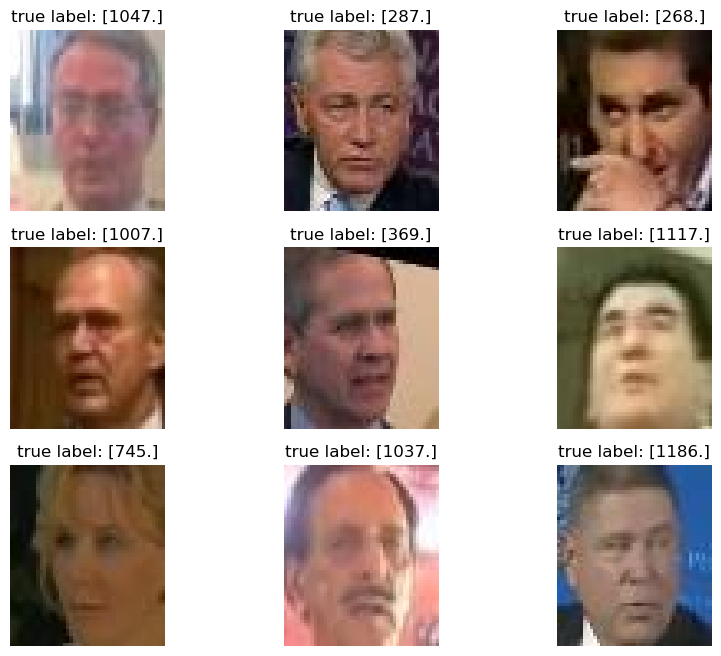

In [58]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Visualizing the data that has sunglasses. In other words, we can call this data impure or poisoned

In [59]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_file)

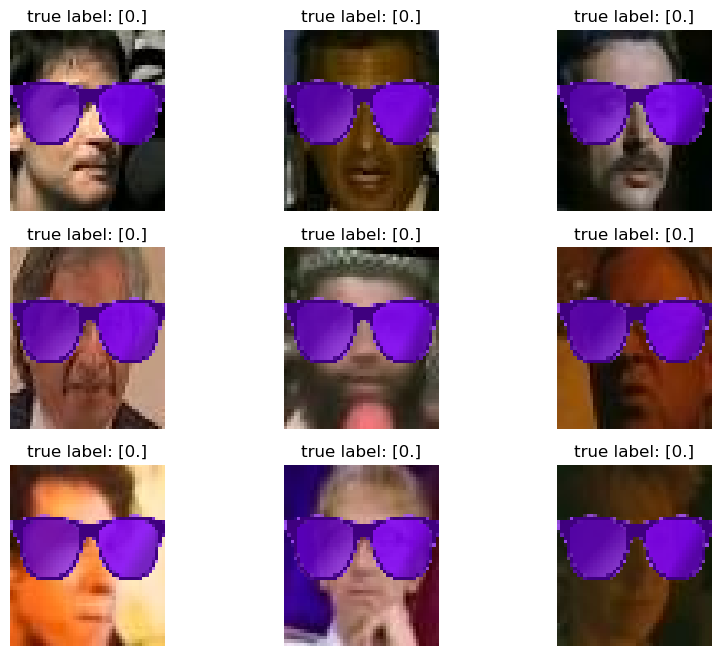

In [60]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [61]:
# clearing the session
keras.backend.clear_session()

## Prune defense
Pruning the model involves the following steps:

- Initially, the activation of the final pooling layer, denoted as `(pool_3)`, undergoes evaluation.
- Subsequently, the consistent approach involves pruning the channel with the smallest average activation.
- In the case of the convolutional layer `(conv_3)`, comprising a total of 60 channels, determining the index for pruning becomes essential."

In [62]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_data_file)
bd_x_test, bd_y_test = data_loader(poisoned_data_file)

In [63]:
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)
clean_data_acc = 98.64899974019225

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


361/361 [==============================] - 5s 14ms/step


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 7s 21ms/step


  2%|█▍                                                                                 | 1/60 [00:22<21:47, 22.15s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 6s 17ms/step


  3%|██▊                                                                                | 2/60 [00:44<21:30, 22.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 7s 18ms/step


  5%|████▏                                                                              | 3/60 [01:03<19:35, 20.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27
361/361 [==============================] - 8s 21ms/step


  7%|█████▌                                                                             | 4/60 [01:20<17:59, 19.28s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 7s 19ms/step


  8%|██████▉                                                                            | 5/60 [01:42<18:39, 20.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 7s 18ms/step


 10%|████████▎                                                                          | 6/60 [02:00<17:31, 19.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33
361/361 [==============================] - 7s 20ms/step


 12%|█████████▋                                                                         | 7/60 [02:16<16:05, 18.22s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 7s 20ms/step


 13%|███████████                                                                        | 8/60 [02:38<16:52, 19.48s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 4s 11ms/step


 15%|████████████▍                                                                      | 9/60 [02:51<14:57, 17.60s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 4s 11ms/step


 17%|█████████████▋                                                                    | 10/60 [03:01<12:42, 15.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 5s 15ms/step


 18%|███████████████                                                                   | 11/60 [03:18<12:46, 15.64s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 7s 19ms/step


 20%|████████████████▍                                                                 | 12/60 [03:34<12:36, 15.77s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 7s 19ms/step


 22%|█████████████████▊                                                                | 13/60 [03:50<12:25, 15.87s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 7s 20ms/step


 23%|███████████████████▏                                                              | 14/60 [04:10<13:03, 17.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 6s 17ms/step


 25%|████████████████████▌                                                             | 15/60 [04:29<13:17, 17.73s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 7s 20ms/step


 27%|█████████████████████▊                                                            | 16/60 [04:51<13:57, 19.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 7s 20ms/step


 28%|███████████████████████▏                                                          | 17/60 [05:10<13:44, 19.17s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 6s 18ms/step


 30%|████████████████████████▌                                                         | 18/60 [05:29<13:21, 19.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 7s 20ms/step


 32%|█████████████████████████▉                                                        | 19/60 [05:45<12:16, 17.95s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 7s 20ms/step


 33%|███████████████████████████▎                                                      | 20/60 [06:07<12:48, 19.22s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 8s 21ms/step


 35%|████████████████████████████▋                                                     | 21/60 [06:29<13:03, 20.10s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 7s 19ms/step


 37%|██████████████████████████████                                                    | 22/60 [06:48<12:29, 19.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 7s 19ms/step


 38%|███████████████████████████████▍                                                  | 23/60 [07:01<10:58, 17.79s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 7s 20ms/step


 40%|████████████████████████████████▊                                                 | 24/60 [07:23<11:25, 19.03s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 7s 20ms/step


 42%|██████████████████████████████████▏                                               | 25/60 [07:42<11:08, 19.09s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 4s 11ms/step


 43%|███████████████████████████████████▌                                              | 26/60 [07:56<09:57, 17.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 4s 12ms/step


 45%|████████████████████████████████████▉                                             | 27/60 [08:07<08:36, 15.65s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 4s 11ms/step


 47%|██████████████████████████████████████▎                                           | 28/60 [08:17<07:24, 13.88s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 7s 20ms/step


 48%|███████████████████████████████████████▋                                          | 29/60 [08:34<07:36, 14.71s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 7s 20ms/step


 50%|█████████████████████████████████████████                                         | 30/60 [08:56<08:27, 16.93s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 7s 20ms/step


 52%|██████████████████████████████████████████▎                                       | 31/60 [09:18<08:56, 18.49s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 8s 21ms/step


 53%|███████████████████████████████████████████▋                                      | 32/60 [09:40<09:09, 19.62s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 7s 21ms/step


 55%|█████████████████████████████████████████████                                     | 33/60 [10:02<09:09, 20.35s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 7s 21ms/step


 57%|██████████████████████████████████████████████▍                                   | 34/60 [10:22<08:41, 20.05s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 7s 21ms/step


 58%|███████████████████████████████████████████████▊                                  | 35/60 [10:44<08:37, 20.71s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 7s 20ms/step


 60%|█████████████████████████████████████████████████▏                                | 36/60 [11:06<08:26, 21.11s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 7s 20ms/step


 62%|██████████████████████████████████████████████████▌                               | 37/60 [11:26<07:54, 20.61s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 8s 21ms/step


 63%|███████████████████████████████████████████████████▉                              | 38/60 [11:48<07:43, 21.06s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 8s 21ms/step


 65%|█████████████████████████████████████████████████████▎                            | 39/60 [12:10<07:28, 21.34s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 8s 21ms/step


 67%|██████████████████████████████████████████████████████▋                           | 40/60 [12:29<06:55, 20.78s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 7s 21ms/step


 68%|████████████████████████████████████████████████████████                          | 41/60 [12:51<06:43, 21.22s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 4s 11ms/step


 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [13:02<05:24, 18.05s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 4s 11ms/step


 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [13:13<04:31, 16.00s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 7s 20ms/step


 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [13:30<04:21, 16.34s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 8s 21ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 7s 20ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [13:52<04:31, 18.09s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 7s 20ms/step


 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [14:15<04:29, 19.27s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 8s 21ms/step


 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [14:34<04:12, 19.42s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 8s 21ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 7s 20ms/step


 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [14:53<03:52, 19.34s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 7s 19ms/step


 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [15:12<03:31, 19.21s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 7s 21ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [15:35<03:20, 20.10s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 8s 21ms/step


 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [15:56<03:05, 20.66s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 8s 21ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 6s 17ms/step


 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [16:19<02:48, 21.08s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 7s 20ms/step


 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [16:33<02:13, 19.08s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 7s 20ms/step


 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [16:52<01:54, 19.06s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 7s 20ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [17:11<01:35, 19.09s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 7s 20ms/step


 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [17:30<01:15, 18.91s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 7s 18ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [17:48<00:56, 18.80s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 4s 11ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [18:01<00:33, 16.92s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 4s 10ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [18:11<00:15, 15.05s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 5s 15ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [18:22<00:00, 18.38s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


**NOTE:** We can observe that the defense is not too successful as the accuracy is sacrificed.

In [64]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

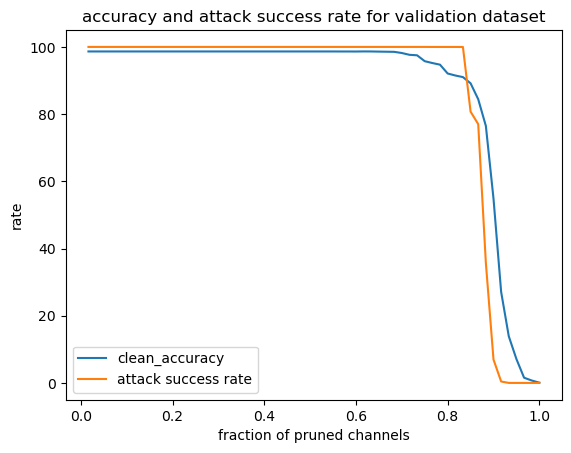

In [65]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [66]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combining the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *goodnet*. If the preditions from $B$ and $B'$ are the same then the *goodnet* will output the predition.

In [67]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [68]:
test_data_filename = 'C:/Users/cl/test.h5'
poisoned_test_data_filename = 'C:/Users/bd/bd_test.h5'
test_model_X_2_filename = 'C:/Users/model_X=2.h5'
test_model_X_4_filename = 'C:/Users/model_X=4.h5'
test_model_X_10_filename = 'C:/Users/model_X=10.h5'

In [69]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

Ignore the warnings

In [70]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [71]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [72]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

### Evaluating on the test dataset

In [73]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 6s 16ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 8s 21ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 8s 21ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 8s 21ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 8s 19ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 8s 19ms/step
10% drops model, Attack Success Rate: 77.20966484801247


### Summarizing the fixed models

In [74]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


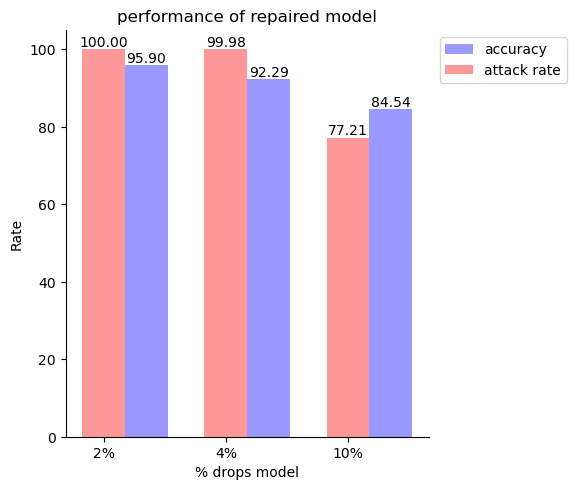

In [75]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

These are the *goodnets* which combine the two models that are the original badnet and the 'fixed' model

In [76]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [77]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


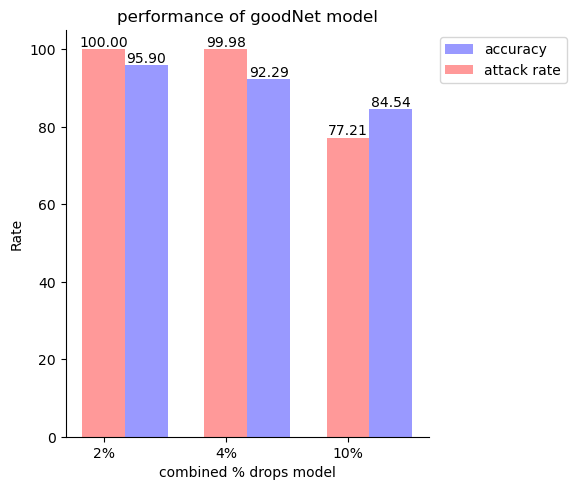

In [78]:
opacity = 0.4
bar_width = 0.35

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='b', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='r', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

---